# CAP 6618 - Machine Learning for Computer Vision

# Programming Project 6 -- Final Project

### Melanoma Dectection using the DermMel dataset from Kaggle

### Imports

In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
# Borrowed from scikit learn

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### vgg19

In [3]:
model = keras.applications.VGG19() 

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Pre-process an image file into a format which vgg19 expects

def prepare_image(file):
    # Image path on local disk
    img_path = 'melanoma/DermMel/'
    # Returns a PIL image
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.vgg19.preprocess_input(img_array_expanded_dims)

In [5]:
def print_image(img_path):

    img = image.load_img(img_path, target_size=(224, 224))   
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

### Let's print a few

Melanoma


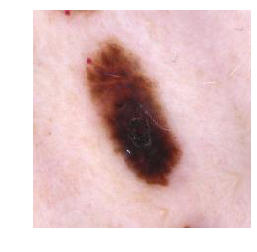

Melanoma


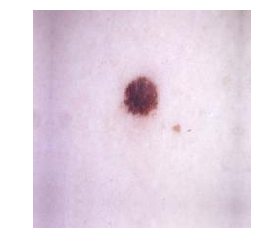

Not Melanoma


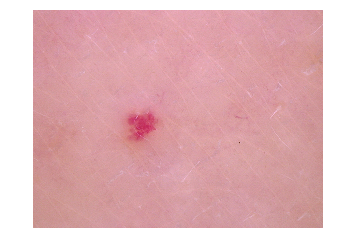

Not Melanoma


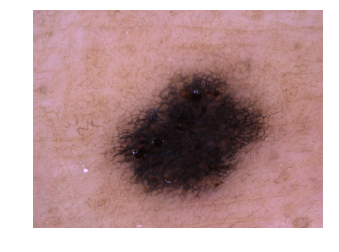

In [6]:
print('Melanoma')
print_image('melanoma/DermMel/train/Melanoma/AUG_0_0.jpeg')
print('Melanoma')
print_image('melanoma/DermMel/train/Melanoma/AUG_0_67.jpeg')
print('Not Melanoma')
print_image('melanoma/DermMel/train/NotMelanoma/ISIC_0024375.jpg')
print('Not Melanoma')
print_image('melanoma/DermMel/train/NotMelanoma/ISIC_0024718.jpg')

#### Well, that's reassuring, who needs health insurance when you can code...moving on

In [7]:
train_path = 'melanoma/DermMel/train'
valid_path = 'melanoma/DermMel/valid'
test_path = 'melanoma/DermMel/test'

#### I grabbed theDermNet dataset from Kaggle. It has 3 gigs of images. Melanoma and NotMelanoma

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg19.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=100)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg19.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=100)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg19.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=100, shuffle = False)

Found 10682 images belonging to 2 classes.
Found 10682 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [9]:
model = keras.applications.VGG19()

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
# Grab the output of the 3rd to last layer of the original mobilnet to use in a new model.
# The new model will consist of the original model, up to the 3rd to last layer.
# So we are NOT including the last 2 layers of the original model.
x = model.layers[-3].output

# Add an output layer with 2 output layers for cat and dog
predictions = Dense(2, activation='softmax')(x)

# Construct a new fine-tuned model
model = Model(inputs=model.input, outputs=predictions)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
# Freeze all layers except the last 5. So only the last 5 layers will be trained.
for layer in model.layers[:-5]:
    layer.trainable = False

In [14]:
model.compile(Adam(lr=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit_generator(train_batches, steps_per_epoch=50, validation_data=valid_batches, validation_steps=2, epochs=3, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
50/50 [==============================] - 2978s 60s/step - loss: 7.9012 - acc: 0.5028 - val_loss: 8.2202 - val_acc: 0.4900
Epoch 2/3
50/50 [==============================] - 2919s 58s/step - loss: 8.0365 - acc: 0.5014 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 3/3
50/50 [==============================] - 2953s 59s/step - loss: 7.9469 - acc: 0.5070 - val_loss: 7.3337 - val_acc: 0.5450


In [16]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
test_batches.class_indices

{'Melanoma': 0, 'NotMelanoma': 1}

In [22]:
pre_processed_image = prepare_image('me.jpeg')
predictions = model.predict(pre_processed_image)
predictions


array([[1., 0.]], dtype=float32)